In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import string
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pickle
plt.style.use('seaborn')

In [2]:
DATA_NAME = 'main_ind'
ADDITIONAL_NAME = '_big'
# WORD-level
MAX_NUM_WORDS     = 15000
EMBEDDING_DIM     = 300
MAX_SEQ_LENGTH    = 500
USE_GLOVE         = True
KERNEL_SIZES      = [3,4,5]
FEATURE_MAPS      = [200,200,200]

# CHAR-level
USE_CHAR          = False
ALPHABET          = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
ALPHABET_SIZE     = len(ALPHABET)
CHAR_MAX_LENGTH   = 1600
CHAR_KERNEL_SIZES = [5,10,20]
CHAR_FEATURE_MAPS = [300,300,300]

# GENERAL
DROPOUT_RATE      = 0.4
HIDDEN_UNITS      = 200

# LEARNING
BATCH_SIZE        = 100
NB_EPOCHS         = 10
RUNS              = 1
VAL_SIZE          = 0.2

In [3]:
def read_files(path):
    data = pd.read_csv(path)
    return [str(doc) for doc in data['content'].tolist()], data['sic_index'].tolist()

In [4]:
docs, labels = read_files(f'data/{DATA_NAME}/{DATA_NAME}{ADDITIONAL_NAME}_train_file.csv')
# docs, labels = read_files(f'data/{DATA_NAME}/{DATA_NAME}{ADDITIONAL_NAME}_test_file.csv')
print(len(docs))
NB_CLASSES = max(labels) + 1
docs[0]

301690


'product manag meet team search wage negoti bonu yesno passion provid tailor person servic sme busi east midland varieti industri spire recruit client candid deal core busi key success feel free contact direct client candid time talk assist tidi organis skill attent detail feet flexibl meet custom post ago vacanc call email visit stabl courtyard staveley hall drive chesterfield tn requir carri reason duti requir compani crimin record convict yesno manag skill overview connect talent industri experi train site park specif sale manag reason leav employ hand connect job seeker effect type hand serv busi client grasp demand activ recruit spire recruit care commun attent detail job regist send cv contact perfect role email close birth fantast term opportun product manag join client base north wingfield product titl mrmrsmsmissdr regist disabl class disabl yesno address product manag avail custom purchas process includ schedul custom servic email phone call offer tailor person servic sme bus

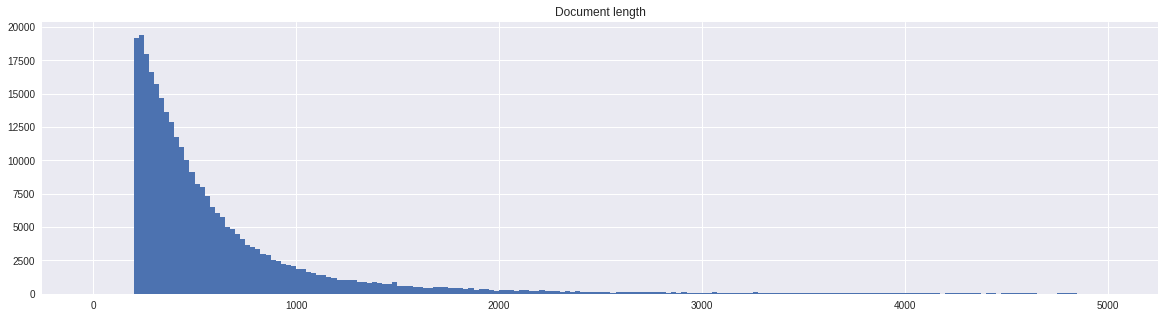

Text informations:
max length: 4997 / min length: 201 / mean length: 623 / limit length: 500
vacobulary size: 1916435 / limit: 15000
Training samples: 301690


In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(docs)

with open(f'data/{DATA_NAME}/{DATA_NAME}{ADDITIONAL_NAME}_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

sequences = tokenizer.texts_to_sequences(docs)

word_index = tokenizer.word_index

result = [len(x.split()) for x in docs]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title('Document length')
plt.hist(result, 200, density=False, range=(0,np.max(result)))
plt.show()


print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                np.min(result),
                                                                                np.mean(result),
                                                                                MAX_SEQ_LENGTH))
print('vacobulary size: %i / limit: %i' % (len(word_index), MAX_NUM_WORDS))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
word_data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')
labels = tf.keras.utils.to_categorical(labels)
print('Training samples: %i' % len(docs))

In [6]:
if USE_CHAR:
    char2idx_dict = {}
    idx2char_dict = {}

    for idx, char in enumerate(ALPHABET):
        char2idx_dict[char] = idx + 1

    idx2char_dict = dict([(i+1, char) for i, char in enumerate(char2idx_dict)])
    
    # Get informations about char length
    result = [len(x) for x in docs]
    plt.figure(figsize=(20,5))
    plt.title('Char length')
    plt.hist(result, 200, density=False, range=(0,np.max(result)))
    plt.show()
    print('Text informations:')
    print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result),
                                                                                    np.min(result),
                                                                                    np.mean(result),
                                                                                    CHAR_MAX_LENGTH))

In [7]:
def char_vectorizer(X):
    str2idx = np.zeros((len(X), CHAR_MAX_LENGTH), dtype='int64')
    for idx, doc in enumerate(X):
        max_length = min(len(doc), CHAR_MAX_LENGTH)
        for i in range(0, max_length):
            c = doc[i]
            if c in char2idx_dict:
                str2idx[idx, i] = char2idx_dict[c]
    return str2idx

In [8]:
def create_glove_embeddings():
    print('Pretrained embedding GloVe is loading...')

    embeddings_index = {}
    with open('glove.6B.%id.txt' % EMBEDDING_DIM) as glove_embedding:
        for line in glove_embedding.readlines():
            values = line.split()
            word   = values[0]
            coefs  = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Found %s word vectors in GloVe embedding\n' % len(embeddings_index))

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        
        if i >= MAX_NUM_WORDS:
            continue
        
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return tf.keras.layers.Embedding(
        input_dim=MAX_NUM_WORDS,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQ_LENGTH,
        weights=[embedding_matrix],
        trainable=True,
        name="word_embedding"
    )

In [9]:
from cnn_model import CNN

emb_layer = None
if USE_GLOVE:
    emb_layer = create_glove_embeddings()

s = time.time()
print("start", time.time() - s)
histories = []

for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    random_state = np.random.randint(1000)
    
    X_train, X_val, y_train, y_val = train_test_split(word_data, labels,
                                                      test_size=VAL_SIZE, random_state=random_state)
    
    if USE_CHAR:
        X_train_c, X_val_c, _, _ = train_test_split(char_vectorizer(docs), tf.keras.utils.to_categorical(labels), 
                                                    test_size=VAL_SIZE, random_state=random_state)
        X_train = [X_train, X_train_c]
        X_val   = [X_val,   X_val_c]
    
    model = CNN(
        embedding_layer   = emb_layer,
        num_words         = MAX_NUM_WORDS,
        embedding_dim     = EMBEDDING_DIM,
        kernel_sizes      = KERNEL_SIZES,
        feature_maps      = FEATURE_MAPS,
        max_seq_length    = MAX_SEQ_LENGTH,
        use_char          = USE_CHAR,
        char_max_length   = CHAR_MAX_LENGTH,
        alphabet_size     = ALPHABET_SIZE,
        char_kernel_sizes = CHAR_KERNEL_SIZES,
        char_feature_maps = CHAR_FEATURE_MAPS,
        dropout_rate      = DROPOUT_RATE,
        hidden_units      = HIDDEN_UNITS,
        nb_classes        = NB_CLASSES
    ).build_model()
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.optimizers.Adam(),
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                f'data/{DATA_NAME}/{DATA_NAME}{ADDITIONAL_NAME}_model-{i+1}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
            ),
        ]
    )

    histories.append(history.history)

seconds = time.time() - s
print(f"Finnishhed in: {seconds} seconds/{seconds/60} minutes.")

Pretrained embedding GloVe is loading...
Found 400000 word vectors in GloVe embedding

start 4.2438507080078125e-05
Running iteration 1/1
Train on 241352 samples, validate on 60338 samples
Epoch 1/10
241300/241352 [============================>.] - ETA: 0s - loss: 1.7159 - accuracy: 0.4863
Epoch 00001: val_loss improved from inf to 1.53448, saving model to data/main_ind/main_ind_big_model-1.h5
241352/241352 [==============================] - 1451s 6ms/sample - loss: 1.7159 - accuracy: 0.4863 - val_loss: 1.5345 - val_accuracy: 0.5455
Epoch 2/10
241300/241352 [============================>.] - ETA: 0s - loss: 1.5472 - accuracy: 0.5447
Epoch 00002: val_loss improved from 1.53448 to 1.50820, saving model to data/main_ind/main_ind_big_model-1.h5
241352/241352 [==============================] - 1464s 6ms/sample - loss: 1.5472 - accuracy: 0.5447 - val_loss: 1.5082 - val_accuracy: 0.5531
Epoch 3/10
241300/241352 [============================>.] - ETA: 0s - loss: 1.4965 - accuracy: 0.5567
Epoch

In [10]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc'   % (get_avg(histories, 'loss'),
                                                get_avg(histories, 'accuracy')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_accuracy')))

Training: 	1.4965 loss / 0.5567 acc
Validation: 	1.4940 loss / 0.5547 acc


In [11]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

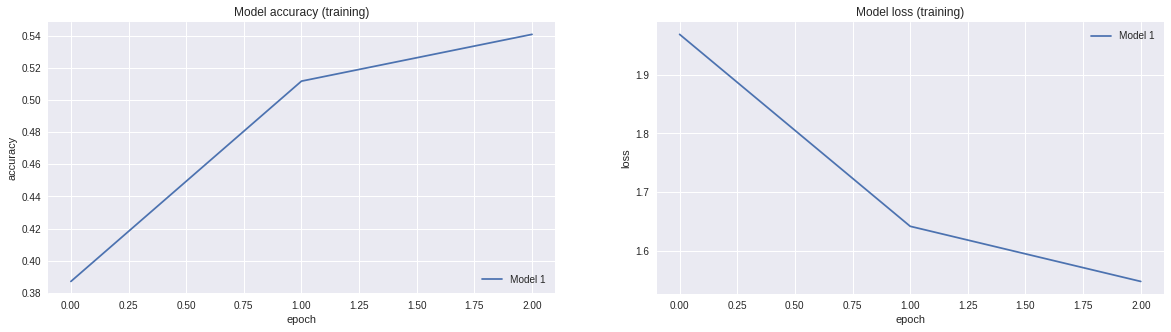

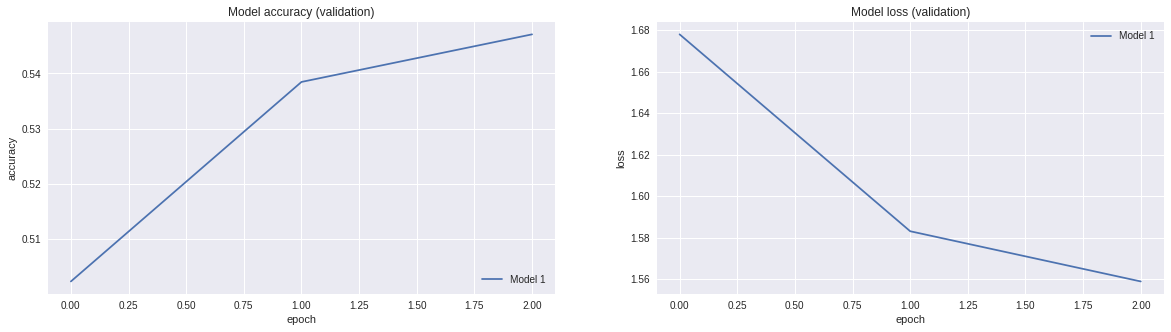

In [12]:
plot_acc_loss('training', histories, 'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')

In [15]:
# X_test, y_test = read_files(f'data/{DATA_NAME}/{DATA_NAME}{ADDITIONAL_NAME}_test_file.csv')
X_test, y_test = read_files(f'data/{DATA_NAME}/{DATA_NAME}{ADDITIONAL_NAME}_train_file.csv')
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_word    = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=MAX_SEQ_LENGTH, padding='post')
y_test = tf.keras.utils.to_categorical(y_test)

if USE_CHAR:
    X_test_word = [X_test_word, char_vectorizer(X_test)]
else:
    X_test_word = X_test_word

In [16]:
import cnn_model

test_loss = []
test_accs = []
RUNS = 1
for i in range(0,RUNS):
    cnn_ = tf.keras.models.load_model(f'data/{DATA_NAME}/{DATA_NAME}{ADDITIONAL_NAME}_model-{i+1}.h5')
    score = cnn_.evaluate(X_test_word, y_test, verbose=2)
    test_loss.append(score[0])
    test_accs.append(score[1])
    print('Running test with model %i: %0.4f loss / %0.4f acc' % (i+1, score[0], score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.4f acc' % (np.mean(test_loss),np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))

301690/1 - 508s - loss: 4.6546 - accuracy: 0.5373
Running test with model 1: 1.5652 loss / 0.5373 acc

Average loss / accuracy on testset: 1.5652 loss / 0.5373 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc


In [40]:
cnn_ = tf.keras.models.load_model( f'data/{DATA_NAME}/{DATA_NAME}{ADDITIONAL_NAME}_model-{i+1}.h5')
for i in range(0,RUNS):
    text = "web design compani cosmo bingo galleri eccl jackpot sun nov congratul lucki cosmo stalybridg winner take massiv tonight nationalbingo game live free membership join cosmo today play tonight home stalybridg session cosmo bingo how to play cosmo bingo titl cosmo bingo cosmo bingo keithle cosmoleisur uk eccl jackpot until won cracker jackpot number less follow us view map eccl jackpot until won membership stalybridg jackpot fri dec even how play cosmoeccl massiv jackpot tonight grab eccl cosmobingo uk eccl session how to play complaint disput procedur cosmo leisur group stalybridg jackpot fri dec afternoon stalybridg jackpot fri dec galleri cosmo bingo titl titl cosmo bingo how to play how to play eccl jackpot sun nov afternoon cosmostali cosmo bingo servic cosmo bingo promot eccl titl cosmo bingo membership membership promot stalybridg eccl jackpot sun nov even main cosmo bingo membership cosmo bingo galleri galleri stalybridg jackpot fri dec snowbal jackpot download discount voucher contact us"
    tokenized = tokenizer.texts_to_sequences([text])
    # print(tokenized)
    np_text = np.array(tokenized)
    # print(np_text)
    text_sequence = tf.keras.preprocessing.sequence.pad_sequences(np_text, maxlen=MAX_SEQ_LENGTH)
    # print(text_sequence)
    prediction = cnn_.predict(text_sequence)
    print('predictions', [p for p in prediction[0]])
    get_class = prediction.argmax(axis=-1)
    print('class', get_class)

predictions [0.013206126, 0.9867938]
class [1]
predictions [0.013206126, 0.9867938]
class [1]
predictions [0.013206126, 0.9867938]
class [1]
predictions [0.013206126, 0.9867938]
class [1]
predictions [0.013206126, 0.9867938]
class [1]
